<a href="https://colab.research.google.com/github/epicure24/ObjectDetection-ComputerVision/blob/main/ResNet_ClassifierRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRAINING RESNET CLASSIFIER CUM REGRESSOR

In [ ]:
#library imports
import os
import random
import math
import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models

HELPER FUNCTIONS

In [ ]:

# READ IMAGES IN COLORED FORMAT
def read_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

# CREATE IMAGE LIST
def create_image_list(image_path):
    image_list = []
    # ITERATE THROUGH IMAGES FOLDER
    for image in os.listdir(image_path):
        # APPEND THE NAME OF IMAGES TO THE LIST
        image_list.append(image)
    return image_list

# CREATE MASK FOR BOUNDING BOX
def create_mask(bb, image):
    # EXTRACT THE IMAGE SHAPE
    rows,cols,*_ = image.shape
    # CREATE A MATRIX OF ZERO OF THE IMAGE SHAPE
    mask = np.zeros((rows, cols))
    # FILL THE MATRIX CONTAINING THE BOUNDING BOX WITH VALUE 1
    mask[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return mask

# CONVERT RESIZED MASK TO BOUNDING BOX
def convert_to_bb(mask):
    # EXTRACT THE SHAPE OF THE MASK OF BOUNDING BOX CREATED
    cols, rows = np.nonzero(mask)
    # RETURN ZERO COORDINATES IF NO MASK
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    # EXTRACT THE BOUNDING BOX COORDINATES
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

# RESIZE THE IMAGES AND SAVE IT IN ANOTHER FOLDER
def image_resize(image_path, new_path, bb, size):
    # READ THE IMAGE FILE
    image = read_image(image_path)
    # RESIZE THE IMAGE
    image_resized = cv2.resize(image, (int(1.49*size), size))
    # CREATE MASK FROM THE BOUNDING BOX
    mask = create_mask(bb, image)
    # RESIZE THE MASK 
    mask_resized = cv2.resize(mask, (int(1.49*size), size))
    # WRITE THE NEW IMAGE INTO ANOTHER FOLDER
    cv2.imwrite(new_path, cv2.cvtColor(image_resized, cv2.COLOR_RGB2BGR))
    return new_path, convert_to_bb(mask_resized)

# PLOT THE BOUNDING BOX AROUND THE IMAGE
def plot_bb(path, bb):
    image = read_image(path)
    # CONVERT BOUNDING BOXES (BB) INTO FLOAT
    bb = np.array(bb, dtype=np.float32)
    # CREATE A RECTANGLE FROM THE BB
    rect_box = plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color='red',
                         fill=False, lw=3)
    # RENDER THE IMAGE
    plt.imshow(image)
    # APPLY THE BB TO THE CURRENT AXIS RENDERING IMAGE
    plt.gca().add_patch(rect_box)

# EXTRACT BOUNDING BOX FROM THE ANNOTATION FILE
def extract_bb(anno_path):
    # PARSE THE XML FILE TO EXTRACT BB COORDINATES AND CLASS_NAME
    root = ET.parse(anno_path).getroot()
    class_name = root.find("./object/name").text
    xmin = int(root.find("./object/bndbox/xmin").text)
    ymin = int(root.find("./object/bndbox/ymin").text)
    xmax = int(root.find("./object/bndbox/xmax").text)
    ymax = int(root.find("./object/bndbox/ymax").text)
    # RETURN BOUNDING BOX COORDINATES
    bb = [ymin, xmin, ymax, xmax]
    return bb, class_name

# GENERATE DATAFRAME
def generate_dataframe(image_list, anno_path, image_path, new_path, size):
    dataset = []
    for image in image_list:
        path = image_path + image
        a_path = anno_path + image.split('.')[0] + '.xml'
        # EXTRACT BB AND CLASS_NAME FROM ANNOTATION FILE
        bb, class_name = extract_bb(a_path)
        # FILENAME OF THE NEW RESIZED IMAGE
        n_path = new_path + image 
        # RESIZE THE IMAGE AND CORRESPONDING BOUNDING BOX 
        img_path, resized_bb = image_resize(path, n_path, bb, size)
        # APPEND EVERYTHING TO A DICTIONARY 
        data = dict()
        data['filename'] = img_path
        data['bb'] = resized_bb
        data['class_name'] = class_name
        # APPEND THE DICTIONARY TO THE LIST
        dataset.append(data)
    # APPEND THE LIST TO THE DATAFRAME 
    return pd.DataFrame(dataset)  

# NORMALIZE THE IMAGE PIXELS TO MATCH IMAGE_NET STATS
def normalize_image(image):
    # IMAGENET STATS 
    stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (image - stats[0])/stats[1] 

# EXTRACT IMAGE FROM THE IMAGE FILE
def extract_image(path):
    x = cv2.imread(str(path)).astype(np.float32)
    # SCALE THE IMAGE PIXELS
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    return x

# TRAIN THE MODEL 
def train_model(model, optimizer, train_dl, val_dl, epochs, C=1000):
    idx = 0
    # ITERATE THROUGH EPOCHS
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        # ITERATE THROUGH THE TENSORS
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            # IMAGE PIXELS TENSOR
            x = x.cuda().float()
            # CLASS TENSORS
            y_class = y_class.cuda()
            # BB TENSORS
            y_bb = y_bb.cuda().float()
            # LOAD THE TENSORS INTO MODEL AND PREDICT THE CLASS_NAMES AND BB
            out_class, out_bb = model(x)
            # CALCULATE LOSS BETWEEN THE ACTUAL & PREDICTED CLASS 
            loss_class = torch.nn.functional.cross_entropy(out_class, y_class, reduction="sum")
            # CALCULATE LOSS BETWEEN THE ACTUAL & PREDICTED BB COORDINATES
            loss_bb = torch.nn.functional.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            # ADD THE 4 BB LOSSES INTO A SINGLE VALUE
            loss_bb = loss_bb.sum()
            # SCALE THE BB LOSS BY 1000 TO HAVE CLASS LOSS AND BB LOSS IN SAME RANGE
            loss = loss_class + loss_bb/C
            # SET GRADIENTS TO ZERO
            optimizer.zero_grad()
            # BACKPROPOGATE THE LOSS
            loss.backward()
            # UPDATE ALL PARAMETERS
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        # CALCULATE THE TOTAL TRAINING LOSS
        train_loss = sum_loss/total
        # CALCULATE THE VALIDATION LOSS AND ACCURACY
        val_loss, val_acc = calculate_validation_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

# FOR CALCULATING VALIDATION LOSS AND ACCURACY
def calculate_validation_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = torch.nn.functional.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = torch.nn.functional.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

# PREPARE THE DATASET TO PASS THROUGH MODEL
class Currency(Dataset):
    def __init__(self, paths, bb, y):
        self.paths = paths.values
        self.bb = bb.values
        self.y = y

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index]
        y_class = self.y[index]
        y_bb = self.bb[index]
        x = extract_image(path)
        x = normalize_image(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

# DEFINE MODEL ARCHITECTURE
class ResNetModel(torch.nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = torch.nn.Sequential(*layers[:6])
        self.features2 = torch.nn.Sequential(*layers[6:])
        self.classifier = torch.nn.Sequential(torch.nn.BatchNorm1d(512), torch.nn.Linear(512, 7))
        self.bb = torch.nn.Sequential(torch.nn.BatchNorm1d(512), torch.nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        y_class = torch.nn.functional.softmax(self.classifier(x), dim=1)
        return y_class, self.bb(x)

## CREATE DATASET

In [ ]:
# CREATE NEW FOLDER
!mkdir resized_image 

image_path = '/content/drive/My Drive/Currency_Images/images/'
anno_path =  '/content/drive/My Drive/Currency_Images/annotations/'
new_path = '/content/resized_image/'

# CREATE IMAGE LIST
image_list = create_image_list(image_path)
# SHUFFLE THE LIST
np.random.shuffle(image_list)

In [ ]:
# CREATE DATAFRAME
dataframe = generate_dataframe(image_list, anno_path, image_path, new_path, 300)

X = dataframe[['filename', 'bb']]
Y = dataframe['class_name']

# ENCODE THE CLASS NAMES
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# SPLIT INTO TRAIN AND VALIDATION SETS
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# CREATE DATASETS
train_ds = Currency(x_train['filename'],x_train['bb'] ,y_train)
valid_ds = Currency(x_val['filename'],x_val['bb'],y_val)

# PREPARE THE BATCH OF TRAINING AND VALIDATION TO LOAD
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

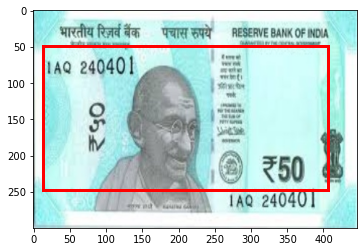

In [ ]:
plot_bb(dataframe['filename'][4], dataframe['bb'][4])

In [ ]:
dataframe.head()

,filename,bb,class_name
0,/content/resized_image/10_30 (copy).jpeg,"[53.0, 89.0, 112.0, 380.0]",ten
1,/content/resized_image/2000_3.jpeg,"[67.0, 37.0, 228.0, 389.0]",twoThousand
2,/content/resized_image/100_43.jpeg,"[82.0, 54.0, 202.0, 445.0]",hundred
3,/content/resized_image/2000_69.jpeg,"[102.0, 89.0, 293.0, 438.0]",twoThousand
4,/content/resized_image/50_1_2.jpeg,"[49.0, 13.0, 248.0, 406.0]",fifty


In [ ]:
Y

array([3, 3, 2, 1, 2, 5, 6, 5, 1, 2, 6, 4, 5, 3, 2, 2, 1, 4, 5, 1, 5, 0,
       6, 2, 4, 4, 0, 4, 3, 3, 0, 3, 1, 2, 1, 0, 1, 3, 4, 3, 0, 0, 3, 4,
       6, 1, 1, 1, 0, 2, 2, 2, 1, 2, 2, 6, 6, 6, 0, 4, 6, 4, 2, 6, 1, 6,
       2, 0, 0, 0, 1, 1, 6, 5, 1, 1, 1, 3, 1, 3, 1, 2, 3, 3, 4, 3, 2, 3,
       0, 4, 5, 1, 0, 6, 0, 2, 1, 1, 4, 3, 0, 2, 0, 2, 6, 0, 2, 6, 6, 1,
       6, 0, 0, 6, 2, 5, 0, 6, 5, 5, 4, 3, 4, 3, 6, 6, 5, 3, 3, 3, 5, 6,
       5, 2, 4, 1, 0, 4, 4, 3, 6, 1, 3, 4, 5, 3, 6, 1, 0, 3, 6, 3, 5, 6,
       5, 6, 3, 0, 1, 5, 2, 2, 4, 1, 4, 6, 1, 1, 4, 1, 4, 6, 3, 6, 3, 2,
       6, 4, 6, 1, 5, 2, 1, 1, 6, 1, 4, 2, 0, 4, 0, 1, 6, 4, 2, 1, 0, 6,
       5, 3, 6, 4, 6, 6, 5, 2, 4, 1, 6, 4, 6, 6, 4, 5, 0, 4, 5, 4, 6, 1,
       3, 5, 6, 2, 2, 4, 1, 3, 2, 4, 3, 1, 5, 1, 1, 6, 6, 4, 6, 5, 4, 5,
       3, 6, 0, 5, 5, 0, 6, 1, 6, 0, 1, 4, 2, 0, 4, 5, 1, 4, 1, 5, 3, 6,
       0, 5, 3, 2, 5, 2, 0, 6, 2, 1, 4, 0, 0, 3, 1, 0, 3, 3, 5, 1, 0, 5,
       4, 4, 6, 1, 3, 4, 3, 5, 2, 3, 4, 3, 5, 6, 2,

In [ ]:
# 0:50 1:500 2:100 3:10 4:20 5:200 6:2000
label_encoder.inverse_transform([0,1,2,3,4,5,6])

array(['fifty', 'fiveHundred', 'hundred', 'ten', 'twenty', 'twoHundred',
       'twoThousand'], dtype=object)

## TRAIN THE MODEL

In [ ]:
# CALL MODEL AND SET PARAMETERS
res_model = ResNetModel().cuda()
parameters = filter(lambda param: param.requires_grad, res_model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)

train_model(res_model, optimizer, train_dl, valid_dl, epochs=50)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



train_loss 2.160 val_loss 2.193 val_acc 0.674
train_loss 1.955 val_loss 2.663 val_acc 0.191
train_loss 1.924 val_loss 2.385 val_acc 0.494
train_loss 1.901 val_loss 2.088 val_acc 0.764
train_loss 1.907 val_loss 2.227 val_acc 0.618
train_loss 1.900 val_loss 2.139 val_acc 0.730
train_loss 1.890 val_loss 2.108 val_acc 0.753
train_loss 1.896 val_loss 2.230 val_acc 0.607
train_loss 1.868 val_loss 2.223 val_acc 0.618
train_loss 1.855 val_loss 2.009 val_acc 0.831
train_loss 1.853 val_loss 2.063 val_acc 0.798
train_loss 1.845 val_loss 1.919 val_acc 0.921
train_loss 1.845 val_loss 1.921 val_acc 0.910
train_loss 1.837 val_loss 1.970 val_acc 0.843
train_loss 1.830 val_loss 2.016 val_acc 0.787
train_loss 1.827 val_loss 1.951 val_acc 0.865
train_loss 1.823 val_loss 1.926 val_acc 0.888
train_loss 1.812 val_loss 1.916 val_acc 0.899
train_loss 1.808 val_loss 1.906 val_acc 0.888
train_loss 1.804 val_loss 1.951 val_acc 0.854
train_loss 1.808 val_loss 1.900 val_acc 0.888
train_loss 1.801 val_loss 1.917 v

1.5906131592663852

## EVALUATE THE MODEL

In [ ]:
test_image = '10_1.jpeg'
test_ds = Currency(pd.DataFrame([{'path':'/content/resized_image/{}'.format(test_image)}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

xx = torch.FloatTensor(x[None,])
# 0 : fifty , 1: fiveHundred , 2: hundred
out_class, out_bb = res_model(xx.cuda())
out_class, out_bb

(tensor([[4.5806e-03, 7.1690e-08, 4.1352e-04, 9.9492e-01, 4.0510e-05, 3.9085e-05,
          1.6834e-06]], device='cuda:0', grad_fn=<SoftmaxBackward>),
 tensor([[54.8928, 36.8687, 72.0823, 72.0866]], device='cuda:0',
        grad_fn=<AddmmBackward>))

10Rs:0.9949245452880859


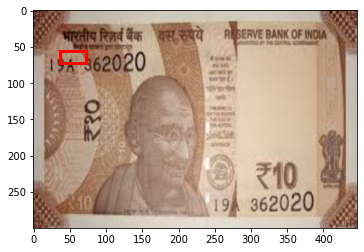

In [ ]:
currency_map = {0:'50Rs', 1:'500Rs', 2:'100Rs', 3:'10Rs', 4:'20Rs', 5:'200Rs', 6:'2000Rs'}

def identify_currency(image_path):

  im = read_image(image_path)
  test_ds = Currency(pd.DataFrame([{'path':'{}'.format(image_path)}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
  x, y_class, y_bb = test_ds[0]
  xx = torch.FloatTensor(x[None,])
  out_class, out_bb = res_model(xx.cuda())
  index = out_class.cpu().data.numpy().argmax()
  confidence = out_class.cpu().data.numpy()[0][index]

  bb_hat = out_bb.detach().cpu().numpy()
  bb_hat = abs(bb_hat)
  plot_bb(image_path, bb_hat[0])
  output = '{}:{}'.format(currency_map[index], confidence)
  print(output)


img_path = '/content/resized_image/{}'.format(test_image)

identify_currency(img_path)

In [ ]:
#save the model
torch.save(res_model, 'res_model.pth')